# PROJECT 7: PREDICTING TIME SERIES

**Author: Ángela Galindo**

In [1]:
# Data Analysiis Stack
import pandas as pd
import numpy as np

# Data Science Stack
from scipy.signal import savgol_filter
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import pmdarima as pm
from numpy.fft import (
    fft,
    fftfreq
)


# Data visualization Stack
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# Other
from datetime import datetime
from helpers import test_stationarity

In [2]:
def fast_fourier_transform(df):
    
    # number of days in the dataframe
    n = len(df)
    
    # frequency in unit of inverse whole period
    freqs = fftfreq(n)
    
    # mask array to be used (removes negative frequency)
    mask = freqs > 0
    
    # masked frequency
    masked_freqs = freqs[mask]
    
    # fast fourier transform
    fft_vals = fft(df)
    
    # true theoretical fft
    fft_theo = 2.0*np.abs(fft_vals/n)
    masked_fft = fft_theo[mask]
    
    return masked_freqs, masked_fft

def dominant_frequency(df):
    
    masked_freqs, masked_fft = fast_fourier_transform(df)

    zipped = sorted(list(zip(masked_freqs, masked_fft)), key=lambda x: x[1], reverse=True)
    freqs = [zipped[i][0] for i in range(len(zipped))]
    ffts  = [round(zipped[i][1],2) for i in range(len(zipped))]
    
    # periods in year
    periods = [round(1/(freq*365.24),2) for freq in freqs]
    
    df1 = pd.DataFrame(data={'freq (per_day)':freqs, 'period (year)': periods, 'amplitude': ffts})
    
    return df1

def frequency_plot(df,max_year):
    freqs, ffts = fast_fourier_transform(df)
    # periods in year
    periods = [round(1/(freq*365.24),2) for freq in freqs]
    
    plt.figure(figsize=(10,4),dpi=100)
    plt.plot(periods, ffts)
    plt.xlabel('period in year')
    plt.ylabel('oscillation ampltiude')
    plt.xlim(0.,max_year)
    plt.title('prominent oscillations in data')


## Load the data (saved from class exercise)

In [3]:
# Load the data
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
train.head()

date  temp
0  1876-01-01   2.2
1  1876-01-02   2.5
2  1876-01-03   0.3
3  1876-01-04  -5.8
4  1876-01-05  -9.8

### Visual inspection of temperature data

In [4]:
# Visualization of the temperature (last 10 years)
years = 10
num_rows = years * 365

ploting = train.iloc[-num_rows:]

fig = px.line(ploting, x="date", y="temp", title="Temperature for the last 10 years") 
fig.show()

In the graph shown above, the signal shows a lot of noise and repetition. This repetition makes reference to what is known in time series as 'seasonality'. 

- The **noise could easely be filtered out** using a low pass filter and used later on in the model.
- We can also **model the seasonality** and try to **inspect** if there is a **trend** in the data.

### Extract the noise

In [5]:
# Extract the noise using a low pass filter
train['signal'] = savgol_filter(np.array(train['temp']), 99, 3, mode='nearest')
train['noise'] = train['temp'] - train['signal']

ploting = train.iloc[-num_rows:]

In [6]:
# Visualization of the temperture (raw and filtered)
fig = make_subplots(
    2,1, 
    #subplot_titles=['Temperature raw', 'Temperature Filtered'],
    #shared_xaxes=True
)

trace1 = go.Scatter(x=ploting['date'], y=ploting['temp'], mode='lines', name='Raw')
trace2 = go.Scatter(x=ploting['date'], y=ploting['signal'], mode='lines', name='Filtered')

fig.add_trace(trace1, row=1, col=1)
fig.add_trace(trace2, row=2, col=1)

fig.update_layout(
    title={'text': "Temperature signal comparison (last 10 years)"},
)

fig.show()


In [7]:
# Visualization of noise
trace = go.Scatter(x=ploting['date'], y=ploting['noise'], mode='lines', name='line plot')
layout = go.Layout(
    title='Noise extracted from temperature signal', 
    xaxis=dict(title='Date'), 
    yaxis=dict(title='Temperature'))
fig = go.Figure(data=[trace], layout=layout)
fig.show()


### Determine trend and seasonality

#### Trend: 
**Find the line that best fits the data to describe trend.**

In [8]:
# CREATE THE FEATURE X THAT WILL BE USED
# y: temperature
# x: timestep (ideally date but we need something we can train with, so we need to translate date)
train['timestep'] = list(range(len(train)))

# Linear regression will find the line that best describes the data (trend)
trend_model = LinearRegression()

# The polynomial model of degree 2 has proved to fit the data better according to previous
# experimenting. Therefore we need to convert X (timestep) to X^2 (timestep^2)
poly = PolynomialFeatures(2)
x_poly = poly.fit_transform(train[['timestep']])
y = train['signal']

trend_model.fit(x_poly, y) 
train['trend'] = trend_model.predict(x_poly)

train.head()


date  temp    signal     noise  timestep     trend
0  1876-01-01   2.2 -0.659391  2.859391         0  9.234793
1  1876-01-02   2.5 -0.772946  3.272946         1  9.234747
2  1876-01-03   0.3 -0.858296  1.158296         2  9.234700
3  1876-01-04  -5.8 -1.025494 -4.774506         3  9.234653
4  1876-01-05  -9.8 -1.151521 -8.648479         4  9.234606

In [9]:
trace1 = go.Scatter(
    x=train['date'],
    y=train['signal'],
    mode='lines',
    name='Temperature')


trace2 = go.Scatter(
    x=train['date'],
    y=train['trend'],
    mode="lines",
    name="Trend"
)

data = [trace1, trace2]

# Define the layout of the chart
layout = go.Layout(
    title='Temperature signal with trend', 
    xaxis=dict(title='Date'), 
    yaxis=dict(title='Temperature'))

fig = go.Figure(data=data, layout=layout)
fig.show()

In [10]:
train['signal_wo_trend'] = train['signal'] -  train['trend']

ploting = train.iloc[-num_rows:]

fig = px.line(ploting, x="date", y="signal_wo_trend", title="Signal without trend for the last 10 years") 
fig.show()

In the first graph shown we saw that the temperature signal was slightly tilted up. Nevertheless, in this last graph we can see that the signal is centered arount the 0 because the trend is no longer there (mean = 0).

#### Seasonality:
**Check the peridoical function that best describes the pattern in the data.**

From our domain knowledge we know that the seasonality in this problem depends on the cycle of 12 months that a year consists of. Nevertheless, this knowledge is specific for this problem and not transfearable for other projects. 

To model seasonality we need to find the combination of periodical functions that best model the periodicity in our data.

* **Periodical functions** = `sine` and `cosine`

To determine the combination of `sines` and `cosines` we need to give the linear model the `sines` and `cosines` to be used during training. Therefore, we need to find the main frequencies that build the signal.  

date  temp    signal     noise  timestep     trend  signal_wo_trend  \
0  1876-01-01   2.2 -0.659391  2.859391         0  9.234793        -9.894184   
1  1876-01-02   2.5 -0.772946  3.272946         1  9.234747       -10.007693   
2  1876-01-03   0.3 -0.858296  1.158296         2  9.234700       -10.092996   
3  1876-01-04  -5.8 -1.025494 -4.774506         3  9.234653       -10.260147   
4  1876-01-05  -9.8 -1.151521 -8.648479         4  9.234606       -10.386128   

        sin       cos  seasonality  
0  0.000000  1.000000    -9.353581  
1  0.017202  0.999852    -9.397464  
2  0.034399  0.999408    -9.438567  
3  0.051585  0.998669    -9.476877  
4  0.068756  0.997633    -9.512382

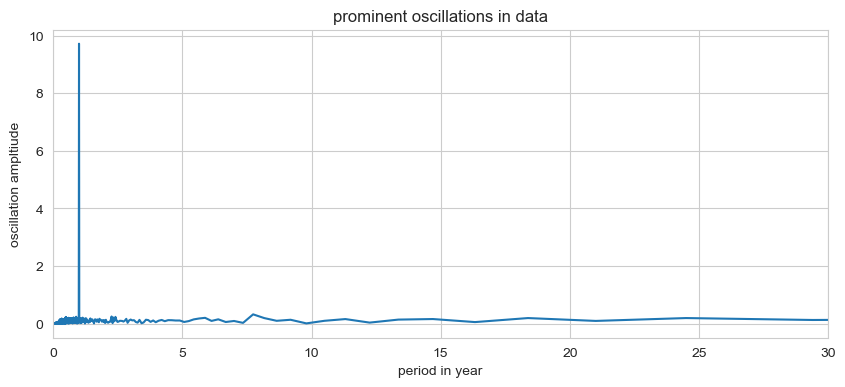

In [11]:
# Plot the periodogram
frequency_plot(train['signal_wo_trend'],30)

# There's only one relevant peak so we only get the most dominant freq
freqs = dominant_frequency(train['signal_wo_trend']).head(1)['freq (per_day)']

train['sin'] = train['timestep'].apply(lambda t: np.sin(2*np.pi*freqs*t))
train['cos'] = train['timestep'].apply(lambda t: np.cos(2*np.pi*freqs*t))

seasonality_model = LinearRegression()

X = train[['sin', 'cos']]
y = train['signal_wo_trend']

seasonality_model.fit(X, y)
train['seasonality'] = seasonality_model.predict(X)

train.head()

In [12]:
years = 10
num_rows = years * 365

ploting = train.iloc[-num_rows:]

trace1 = go.Scatter(
    x=ploting['date'],
    y=ploting['signal_wo_trend'],
    mode='lines',
    name='Temperature')


trace2 = go.Scatter(
    x=ploting['date'],
    y=ploting['seasonality'],
    mode="lines",
    name="Trend"
)

data = [trace1, trace2]

# Define the layout of the chart
layout = go.Layout(
    title='Temperature signal with trend', 
    xaxis=dict(title='Date'), 
    yaxis=dict(title='Temperature'))

fig = go.Figure(data=data, layout=layout)
fig.show()

In [13]:
train['remainder'] = train['signal_wo_trend'] - train['seasonality']

years = 10
num_rows = years * 365

ploting = train.iloc[-num_rows:]

fig = px.line(ploting, x="date", y="remainder", title="Remainder signal") 
fig.show()

**Check stationarity of the model**

In [14]:
test_stationarity(train['remainder'])


 non-stationary: heteroscedastic (qcd = 0.597875) 



In [15]:
remainder_model = pm.auto_arima(
    train['remainder'],
    start_p=0,
    max_p=2,
    seasonality = False,
    stationarity = False,
    trace = True,
    n_jobs=-1
);

print(remainder_model.summary())


/Users/angelagalindo/opt/anaconda3/lib/python3.9/site-packages/pmdarima/arima/_validation.py:76: UserWarning:

stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.



Performing stepwise search to minimize aic
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=71446.617, Time=18.76 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=211686.731, Time=0.86 sec


/Users/angelagalindo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning:

invalid value encountered in reciprocal



 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=6.51 sec


/Users/angelagalindo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning:

invalid value encountered in reciprocal



 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=138381.847, Time=9.77 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=211684.731, Time=0.44 sec


/Users/angelagalindo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning:

invalid value encountered in reciprocal



 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-156884.435, Time=22.89 sec


/Users/angelagalindo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning:

invalid value encountered in reciprocal

/Users/angelagalindo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning:

invalid value encountered in reciprocal



 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-141037.298, Time=16.54 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-172093.464, Time=31.63 sec


/Users/angelagalindo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning:

invalid value encountered in reciprocal



 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-171702.277, Time=29.33 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-172388.303, Time=52.69 sec


/Users/angelagalindo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning:

invalid value encountered in reciprocal



 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-163302.164, Time=23.00 sec
 ARIMA(2,0,4)(0,0,0)[0] intercept   : AIC=-172497.305, Time=31.90 sec


/Users/angelagalindo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning:

invalid value encountered in reciprocal



 ARIMA(1,0,4)(0,0,0)[0] intercept   : AIC=-166302.393, Time=59.13 sec
 ARIMA(2,0,5)(0,0,0)[0] intercept   : AIC=-172532.674, Time=75.94 sec


/Users/angelagalindo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning:

invalid value encountered in reciprocal



 ARIMA(1,0,5)(0,0,0)[0] intercept   : AIC=-168058.109, Time=40.41 sec
 ARIMA(2,0,5)(0,0,0)[0]             : AIC=-172531.438, Time=17.88 sec

Best model:  ARIMA(2,0,5)(0,0,0)[0] intercept
Total fit time: 437.704 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                53691
Model:               SARIMAX(2, 0, 5)   Log Likelihood               86275.337
Date:                Fri, 12 May 2023   AIC                        -172532.674
Time:                        10:27:14   BIC                        -172452.655
Sample:                             0   HQIC                       -172507.691
                              - 53691                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------

In [17]:
train['remainder_predict'] = remainder_model.predict_in_sample()

years = 10
num_rows = years * 365

ploting = train.iloc[-num_rows:]

trace1 = go.Scatter(
    x=ploting['date'],
    y=ploting['remainder'],
    mode='lines',
    name='remainder')


trace2 = go.Scatter(
    x=ploting['date'],
    y=ploting['remainder_predict'],
    mode="lines",
    name="remainder_predict"
)

data = [trace1, trace2]

# Define the layout of the chart
layout = go.Layout(
    title='Remainder: Prediction vs actual plotted', 
    xaxis=dict(title='Date'), 
    yaxis=dict(title='Temperature'))

fig = go.Figure(data=data, layout=layout)
fig.show()

**Check stationarity of noise signal**

In [16]:
test_stationarity(train['noise'])


 p_adf: 0.0, p_kpss: 0.1

 stationary or seasonal-stationary


/Users/angelagalindo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




In [18]:
noise_model = pm.auto_arima(
    train['noise'],
    start_p=0,
    max_p=2,
    seasonality = False,
    stationarity = True,
    trace = True,
    n_jobs=-1
);

print(noise_model.summary())

/Users/angelagalindo/opt/anaconda3/lib/python3.9/site-packages/pmdarima/arima/_validation.py:76: UserWarning:

stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.



Performing stepwise search to minimize aic
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=240177.652, Time=5.98 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=281014.350, Time=0.70 sec


/Users/angelagalindo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning:

invalid value encountered in reciprocal



 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=237947.817, Time=1.55 sec


/Users/angelagalindo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning:

invalid value encountered in reciprocal



 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=248842.149, Time=4.30 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=281012.360, Time=0.43 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=236244.516, Time=2.54 sec


/Users/angelagalindo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning:

invalid value encountered in reciprocal



 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=236168.317, Time=8.91 sec


/Users/angelagalindo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning:

invalid value encountered in reciprocal

/Users/angelagalindo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning:

invalid value encountered in reciprocal



 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=236167.313, Time=4.14 sec


/Users/angelagalindo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning:

invalid value encountered in reciprocal



 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=236168.405, Time=3.70 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=236170.934, Time=9.80 sec


/Users/angelagalindo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning:

invalid value encountered in reciprocal

/Users/angelagalindo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning:

invalid value encountered in reciprocal



 ARIMA(1,0,1)(0,0,0)[0]             : AIC=236165.314, Time=1.93 sec


/Users/angelagalindo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning:

invalid value encountered in reciprocal



 ARIMA(0,0,1)(0,0,0)[0]             : AIC=248840.154, Time=1.66 sec


/Users/angelagalindo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning:

invalid value encountered in reciprocal



 ARIMA(1,0,0)(0,0,0)[0]             : AIC=237945.817, Time=0.73 sec


/Users/angelagalindo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning:

invalid value encountered in reciprocal



 ARIMA(2,0,1)(0,0,0)[0]             : AIC=236166.318, Time=3.66 sec


/Users/angelagalindo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning:

invalid value encountered in reciprocal



 ARIMA(1,0,2)(0,0,0)[0]             : AIC=236166.406, Time=1.72 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=240175.655, Time=2.78 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=236242.517, Time=1.32 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=236168.935, Time=4.71 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 60.594 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                53691
Model:               SARIMAX(1, 0, 1)   Log Likelihood             -118079.657
Date:                Fri, 12 May 2023   AIC                         236165.314
Time:                        10:28:21   BIC                         236191.987
Sample:                             0   HQIC                        236173.642
                              - 53691                                         
Covariance Type:                  opg                                         
                 c

In [19]:
train['noise_predict'] = noise_model.predict_in_sample()

years = 10
num_rows = years * 365

ploting = train.iloc[-num_rows:]

trace1 = go.Scatter(
    x=ploting['date'],
    y=ploting['noise'],
    mode='lines',
    name='Temperature')


trace2 = go.Scatter(
    x=ploting['date'],
    y=ploting['noise_predict'],
    mode="lines",
    name="Trend"
)

data = [trace1, trace2]

# Define the layout of the chart
layout = go.Layout(
    title='Noise: Prediction vs actual plotted', 
    xaxis=dict(title='Date'), 
    yaxis=dict(title='Temperature'))

fig = go.Figure(data=data, layout=layout)
fig.show()

### Make predictions for all 4 models and add them

In [20]:
test = pd.read_csv('./data/test.csv')

test['timestep'] = list(range(len(train),len(train)+len(test)))

# Predict trend
x_poly = poly.transform(test[['timestep']])
test['trend_pred'] = trend_model.predict(x_poly)

# Predict seasonality
test['sin'] = test['timestep'].apply(lambda t: np.sin(2*np.pi*freqs*t))
test['cos'] = test['timestep'].apply(lambda t: np.cos(2*np.pi*freqs*t))

test['seasonality_pred'] = seasonality_model.predict(test[['sin', 'cos']])

# Predict the remainder
remainder_pred = remainder_model.predict(test.shape[0], return_conf_int=True)[0]
test['remainder_pred'] = remainder_pred.reset_index(drop=True)

# # Predict the noise
noise_pred = noise_model.predict(test.shape[0], return_conf_int=True)[0]
test['noise_pred'] = noise_pred.reset_index(drop=True)

test.head()

date  temp  timestep  trend_pred           sin       cos  \
0  2023-01-01  14.5     53691   11.086482 -9.995346e-14  1.000000   
1  2023-01-02  13.1     53692   11.086598  1.720182e-02  0.999852   
2  2023-01-03   5.6     53693   11.086714  3.439854e-02  0.999408   
3  2023-01-04   7.1     53694   11.086830  5.158509e-02  0.998669   
4  2023-01-05   8.2     53695   11.086945  6.875637e-02  0.997633   

   seasonality_pred  remainder_pred  noise_pred  
0         -9.353581        6.992152    5.839353  
1         -9.397464        7.283472    3.722824  
2         -9.438567        7.523787    2.373452  
3         -9.476877        7.724196    1.513172  
4         -9.512382        7.891231    0.964708

In [21]:
test['temp_pred'] = round(
    test['remainder_pred'] + test['noise_pred'] + test['seasonality_pred'] + test['trend_pred'])

In [22]:
result = test[['date', 'temp', 'temp_pred']]
result.head()

date  temp  temp_pred
0  2023-01-01  14.5       15.0
1  2023-01-02  13.1       13.0
2  2023-01-03   5.6       12.0
3  2023-01-04   7.1       11.0
4  2023-01-05   8.2       10.0

In [23]:
trace1 = go.Scatter(
    x=result['date'],
    y=result['temp'],
    mode='lines',
    name='Test temperature')

trace2 = go.Scatter(
    x=result['date'],
    y=result['temp_pred'],
    mode="lines",
    name="Temperature predicted"
)

data = [trace1, trace2]

# Define the layout of the chart
layout = go.Layout(
    title='Temperature: actual vs prediction', 
    xaxis=dict(title='Date'), 
    yaxis=dict(title='Temperature'))

fig = go.Figure(data=data, layout=layout)
fig.show()